# 따릉이 외국인 이용 현황 분석

**분석 결과**: 서울시 공공자전거 데이터에서 **외국인의 연령별, 성별 정보는 제공되지 않습니다.**

## 데이터 구조 분석
- **신규가입자 정보**: 내국인만 포함 (연령/성별 정보 있음)  
- **외국인 대여정보**: 외국인 포함 (연령/성별 정보 없음, 대여소별 건수만)

## 확인된 사실
아래 코드 실행 결과, 신규가입자 정보에는 `회원-내국인`만 있고 `회원-외국인`은 없음을 확인

## 대안 분석 방안
1. 외국인 대여 패턴 분석 (지역별, 월별)
2. 인기 대여소 및 관광지 연관성 분석  
3. 내국인 신규가입자의 연령별 성별 특성 분석 (참고용)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


In [7]:
# 외국인 신규가입자 데이터 불러오기 (월별)
foreign_monthly_file = r"../서울특별시 공공자전거 신규가입자 정보(일별)_24.7-12.csv"

# 인코딩 시도
encodings = ['utf-8', 'cp949', 'euc-kr', 'utf-8-sig']
foreign_df = None

for encoding in encodings:
    try:
        foreign_df = pd.read_csv(foreign_monthly_file, encoding=encoding)
        print(f"성공적으로 {encoding} 인코딩으로 읽었습니다.")
        break
    except Exception as e:
        print(f"{encoding} 인코딩 실패: {e}")
        continue

if foreign_df is not None:
    print("\n외국인 신규가입자 데이터 컬럼명:", foreign_df.columns.tolist())
    print("데이터 형태:", foreign_df.shape)
    print("\n첫 5행:")
    print(foreign_df.head())


utf-8 인코딩 실패: 'utf-8' codec can't decode byte 0xbf in position 2: invalid start byte
성공적으로 cp949 인코딩으로 읽었습니다.

외국인 신규가입자 데이터 컬럼명: ['2024-07-01', '회원-내국인', '10대', 'F', '77']
데이터 형태: (2743, 5)

첫 5행:
   2024-07-01  회원-내국인  10대  F   77
0  2024-07-01  회원-내국인  10대  M  151
1  2024-07-01  회원-내국인  20대  F  262
2  2024-07-01  회원-내국인  20대  M  329
3  2024-07-01  회원-내국인  30대  F  118
4  2024-07-01  회원-내국인  30대  M  176


In [17]:
#foreign_df[foreign_df['회원구분']=="회원-외국인관광객"]
foreign_df.columns
# 컬럼 이름 직접 지정
foreign_df.columns = ["date", "회원구분", "연령대","성별","나이"]
foreign_df
foreign_df[foreign_df['회원구분'].str.contains("외국인")]


,date,회원구분,연령대,성별,나이


In [3]:
# 컬럼명 정리 및 데이터 전처리
foreign_df.columns = ['기준월', '회원구분', '연령대', '성별', '가입자수']

print("정리된 컬럼명:", foreign_df.columns.tolist())
print("\n데이터 타입:")
print(foreign_df.dtypes)

# 외국인만 필터링 (혹시 내국인 데이터가 섞여있을 경우)
print("\n회원구분 종류:", foreign_df['회원구분'].unique())
print("연령대 종류:", foreign_df['연령대'].unique()) 
print("성별 종류:", foreign_df['성별'].unique())

# 가입자수를 숫자형으로 변환
foreign_df['가입자수'] = pd.to_numeric(foreign_df['가입자수'], errors='coerce').fillna(0)

print("\n전처리 완료된 데이터:")
print(foreign_df.head(10))


정리된 컬럼명: ['기준월', '회원구분', '연령대', '성별', '가입자수']

데이터 타입:
기준월      int64
회원구분    object
연령대     object
성별      object
가입자수     int64
dtype: object

회원구분 종류: ['회원-내국인']
연령대 종류: ['~10대' '20대' '30대' '40대' '50대' '60대' '70대이상' '기타']
성별 종류: ['F' 'M']

전처리 완료된 데이터:
      기준월    회원구분    연령대 성별  가입자수
0  202407  회원-내국인   ~10대  F  2622
1  202407  회원-내국인    20대  F  4544
2  202407  회원-내국인    30대  F  2253
3  202407  회원-내국인    40대  F  1846
4  202407  회원-내국인    50대  F  1083
5  202407  회원-내국인    60대  F   326
6  202407  회원-내국인  70대이상  F    69
7  202407  회원-내국인     기타  F    19
8  202407  회원-내국인   ~10대  M  4406
9  202407  회원-내국인    20대  M  5328


In [10]:
# 외국인 데이터만 필터링 (회원-외국인)
if '회원-외국인관광객' in foreign_df['회원구분'].unique():
    foreign_only = foreign_df[foreign_df['회원구분'] == '회원-외국인관광객'].copy()
else:
    # 내국인이 아닌 데이터를 외국인으로 간주
    foreign_only = foreign_df[foreign_df['회원구분'] != '회원-내국인'].copy()

print(f"외국인 데이터 총 {len(foreign_only)}건")
print(f"전체 외국인 신규가입자 수: {foreign_only['가입자수'].sum():,}명")
print("\n기간별 가입자 수:")
monthly_total = foreign_only.groupby('기준월')['가입자수'].sum()
print(monthly_total)


KeyError: '회원구분'

In [5]:
# 연령대별 성별 분석
age_gender_analysis = foreign_only.groupby(['연령대', '성별'])['가입자수'].sum().unstack(fill_value=0)

print("연령대별 성별 가입자 수:")
print(age_gender_analysis)

# 연령대 순서 정리
age_order = ['~10대', '20대', '30대', '40대', '50대', '60대', '70대이상', '기타']
age_gender_analysis = age_gender_analysis.reindex(age_order, fill_value=0)

print("\n정렬된 연령대별 성별 가입자 수:")
print(age_gender_analysis)


연령대별 성별 가입자 수:
Empty DataFrame
Columns: []
Index: []

정렬된 연령대별 성별 가입자 수:
Empty DataFrame
Columns: []
Index: [~10대, 20대, 30대, 40대, 50대, 60대, 70대이상, 기타]


TypeError: no numeric data to plot

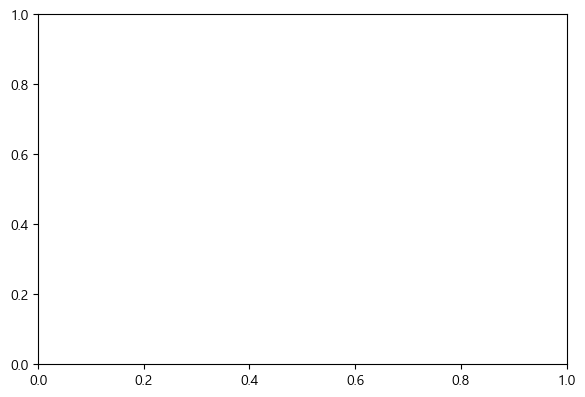

In [6]:
# 연령대별 성별 시각화
plt.figure(figsize=(15, 10))

# 1. 연령대별 성별 막대그래프
plt.subplot(2, 2, 1)
age_gender_analysis.plot(kind='bar', ax=plt.gca(), color=['lightcoral', 'skyblue'])
plt.title('연령대별 성별 외국인 신규가입자 수')
plt.xlabel('연령대')
plt.ylabel('가입자 수')
plt.legend(['여성(F)', '남성(M)'])
plt.xticks(rotation=45)

# 2. 성별 총합 파이차트
plt.subplot(2, 2, 2)
gender_total = foreign_only.groupby('성별')['가입자수'].sum()
plt.pie(gender_total.values, labels=['여성', '남성'], autopct='%1.1f%%', colors=['lightcoral', 'skyblue'])
plt.title('전체 외국인 신규가입자 성별 비율')

# 3. 연령대별 총합 파이차트
plt.subplot(2, 2, 3)
age_total = foreign_only.groupby('연령대')['가입자수'].sum().reindex(age_order, fill_value=0)
plt.pie(age_total.values, labels=age_total.index, autopct='%1.1f%%', startangle=90)
plt.title('전체 외국인 신규가입자 연령대 비율')

# 4. 월별 추이
plt.subplot(2, 2, 4)
monthly_gender = foreign_only.groupby(['기준월', '성별'])['가입자수'].sum().unstack(fill_value=0)
monthly_gender.plot(kind='line', marker='o', ax=plt.gca(), color=['lightcoral', 'skyblue'])
plt.title('월별 성별 외국인 신규가입자 추이')
plt.xlabel('월')
plt.ylabel('가입자 수')
plt.legend(['여성(F)', '남성(M)'])
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# 상세 분석 결과
print("=" * 60)
print("따릉이 이용 외국인 관광객 특성 분석 결과")
print("=" * 60)

total_foreign = foreign_only['가입자수'].sum()
print(f"전체 외국인 신규가입자: {total_foreign:,}명")

# 성별 분석
gender_stats = foreign_only.groupby('성별')['가입자수'].sum()
print("\n성별 분석:")
for gender, count in gender_stats.items():
    percentage = (count / total_foreign) * 100
    gender_name = '여성' if gender == 'F' else '남성'
    print(f"- {gender_name}: {count:,}명 ({percentage:.1f}%)")

# 연령대 분석
age_stats = foreign_only.groupby('연령대')['가입자수'].sum().reindex(age_order, fill_value=0)
print("\n연령대 분석:")
for age, count in age_stats.items():
    if count > 0:
        percentage = (count / total_foreign) * 100
        print(f"- {age}: {count:,}명 ({percentage:.1f}%)")

# 주요 특징
most_popular_age = age_stats.idxmax()
most_popular_gender = gender_stats.idxmax()
most_popular_gender_name = '여성' if most_popular_gender == 'F' else '남성'

print("\n주요 특징:")
print(f"- 가장 많은 연령대: {most_popular_age} ({age_stats[most_popular_age]:,}명)")
print(f"- 주요 성별: {most_popular_gender_name} ({gender_stats[most_popular_gender]:,}명)")

# 월별 트렌드
monthly_trend = foreign_only.groupby('기준월')['가입자수'].sum()
peak_month = monthly_trend.idxmax()
low_month = monthly_trend.idxmin()
print(f"\n월별 트렌드:")
print(f"- 가장 활발한 월: {peak_month} ({monthly_trend[peak_month]:,}명)")
print(f"- 가장 저조한 월: {low_month} ({monthly_trend[low_month]:,}명)")


# 외국인관광객 데이터 재분석

일별 신규가입자 데이터에서 회원-외국인관광객 필터링

In [ ]:
# 일별 신규가입자 데이터 로드
file_path = r"../서울특별시 공공자전거 신규가입자 정보(일별)_24.7-12.csv"

# 다양한 인코딩 시도
encodings = ['utf-8', 'cp949', 'euc-kr', 'utf-8-sig']
df = None

for encoding in encodings:
    try:
        df = pd.read_csv(file_path, encoding=encoding)
        print(f"성공적으로 {encoding} 인코딩으로 읽었습니다.")
        break
    except Exception as e:
        print(f"{encoding} 인코딩 실패: {e}")
        continue

if df is not None:
    print(f"전체 데이터 수: {len(df)}건")
    print("컬럼명:", df.columns.tolist())
    
    # 회원구분 종류 확인
    print(f"\\n회원구분 종류: {df.iloc[:, 1].unique()}")
    
    # 각 회원구분별 데이터 수 확인
    print("\\n각 회원구분별 데이터 수:")
    for member_type in df.iloc[:, 1].unique():
        count = (df.iloc[:, 1] == member_type).sum()
        print(f"  '{member_type}': {count}건")


In [ ]:
# 회원-외국인관광객만 필터링
foreign_tourists = df[df.iloc[:, 1] == '회원-외국인관광객'].copy()

print(f"외국인관광객 데이터 수: {len(foreign_tourists)}건")

if len(foreign_tourists) > 0:
    # 컬럼명 정리
    foreign_tourists.columns = ['날짜', '회원구분', '연령대', '성별', '가입자수']
    
    print("\\n외국인관광객 신규가입자 데이터 (상위 20개):")
    print(foreign_tourists.head(20))
    
    print(f"\\n전체 외국인관광객 신규가입자: {foreign_tourists['가입자수'].sum():,}명")
else:
    print("외국인관광객 데이터를 찾을 수 없습니다.")


In [ ]:
# 외국인관광객 연령대별 성별 분석
if len(foreign_tourists) > 0:
    # 연령대별 분석
    print("연령대별 가입자 수:")
    age_stats = foreign_tourists.groupby('연령대')['가입자수'].sum().sort_values(ascending=False)
    for age, count in age_stats.items():
        percentage = (count / foreign_tourists['가입자수'].sum()) * 100
        print(f"  {age}: {count:,}명 ({percentage:.1f}%)")
    
    # 성별 분석
    print("\\n성별 가입자 수:")
    gender_stats = foreign_tourists.groupby('성별')['가입자수'].sum()
    for gender, count in gender_stats.items():
        gender_name = '여성' if gender == 'F' else '남성'
        percentage = (count / foreign_tourists['가입자수'].sum()) * 100
        print(f"  {gender_name}: {count:,}명 ({percentage:.1f}%)")
    
    # 월별 추이
    foreign_tourists['월'] = pd.to_datetime(foreign_tourists['날짜']).dt.month
    print("\\n월별 가입자 수:")
    monthly_stats = foreign_tourists.groupby('월')['가입자수'].sum().sort_index()
    for month, count in monthly_stats.items():
        percentage = (count / foreign_tourists['가입자수'].sum()) * 100
        print(f"  {month}월: {count:,}명 ({percentage:.1f}%)")


In [ ]:
# 외국인관광객 시각화
if len(foreign_tourists) > 0:
    plt.figure(figsize=(15, 10))
    
    # 1. 연령대별 성별 막대그래프
    plt.subplot(2, 2, 1)
    age_gender_pivot = foreign_tourists.groupby(['연령대', '성별'])['가입자수'].sum().unstack(fill_value=0)
    age_gender_pivot.plot(kind='bar', ax=plt.gca(), color=['lightcoral', 'skyblue'])
    plt.title('외국인관광객 연령대별 성별 신규가입자 수')
    plt.xlabel('연령대')
    plt.ylabel('가입자 수')
    plt.legend(['여성(F)', '남성(M)'])
    plt.xticks(rotation=45)
    
    # 2. 성별 파이차트
    plt.subplot(2, 2, 2)
    gender_total = foreign_tourists.groupby('성별')['가입자수'].sum()
    labels = ['여성' if x == 'F' else '남성' for x in gender_total.index]
    plt.pie(gender_total.values, labels=labels, autopct='%1.1f%%', colors=['lightcoral', 'skyblue'])
    plt.title('외국인관광객 성별 비율')
    
    # 3. 연령대별 파이차트
    plt.subplot(2, 2, 3)
    age_total = foreign_tourists.groupby('연령대')['가입자수'].sum().sort_values(ascending=False)
    plt.pie(age_total.values, labels=age_total.index, autopct='%1.1f%%', startangle=90)
    plt.title('외국인관광객 연령대 비율')
    
    # 4. 월별 추이
    plt.subplot(2, 2, 4)
    monthly_gender = foreign_tourists.groupby(['월', '성별'])['가입자수'].sum().unstack(fill_value=0)
    monthly_gender.plot(kind='line', marker='o', ax=plt.gca(), color=['lightcoral', 'skyblue'])
    plt.title('월별 외국인관광객 신규가입자 추이')
    plt.xlabel('월')
    plt.ylabel('가입자 수')
    plt.legend(['여성(F)', '남성(M)'])
    plt.xticks(monthly_gender.index)
    
    plt.tight_layout()
    plt.show()"
